In [ ]:
!pip install transformers datasets evaluate transformers[torch]

In [ ]:
!pip install rouge_score

In [ ]:
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt
from transformers import BartForConditionalGeneration, AutoTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, TrainerCallback
import torch
import pandas as pd
import numpy as np

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [ ]:
dataset = load_dataset("multi_news")
print(dataset)
print(f"Features: {dataset['train'].column_names}")

In [ ]:
model_ckpt = "sshleifer/distilbart-cnn-6-6"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = BartForConditionalGeneration.from_pretrained(model_ckpt)

In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["document"], max_length=1024, truncation=True)
    target_encodings = tokenizer(text_target=example_batch["summary"], max_length=256, truncation=True)

    return {"input_ids": input_encodings["input_ids"],
           "attention_mask": input_encodings["attention_mask"],
           "labels": target_encodings["input_ids"]}

new_dataset = dataset.map(convert_examples_to_features, batched=True)

In [ ]:
columns = ["input_ids", "labels", "attention_mask"]
new_dataset.set_format(type="torch", columns=columns)

In [ ]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
rouge = load_metric("rouge")

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    labels_ids = np.where(labels_ids == -100, tokenizer.pad_token_id, labels_ids)
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(
        predictions=pred_str, references=label_str, rouge_types=["rouge2"]
    )["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

In [ ]:
training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    fp16=True,
    weight_decay=0.01,
    output_dir="./results",
    logging_dir='./logs',
    logging_steps=1,
    eval_steps=10,
    load_best_model_at_end=True,
    num_train_epochs=1
)

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    data_collator=seq2seq_data_collator,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=new_dataset['train'],
    eval_dataset=new_dataset['validation']
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
10,3.063700,3.052451,0.150800,0.092000,0.113100
20,3.354100,2.857514,0.168200,0.101200,0.125100
30,2.872200,2.804843,0.172900,0.105700,0.129700
40,2.107300,2.777484,0.166900,0.100900,0.124400
50,2.854600,2.753327,0.179400,0.109200,0.134400
60,2.332700,2.735941,0.175600,0.106800,0.131500
70,2.593900,2.730905,0.168800,0.103100,0.126700
80,3.149600,2.722593,0.175100,0.107100,0.131600
90,2.539100,2.711595,0.173400,0.104800,0.129400
100,2.667900,2.696645,0.179800,0.109800,0.135100


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=563, training_loss=2.7759140033281504, metrics={'train_runtime': 26898.3793, 'train_samples_per_second': 0.167, 'train_steps_per_second': 0.021, 'total_flos': 4873874848088064.0, 'train_loss': 2.7759140033281504, 'epoch': 1.0})

In [ ]:
trainer.save_model('./results/bert_news_summary/model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


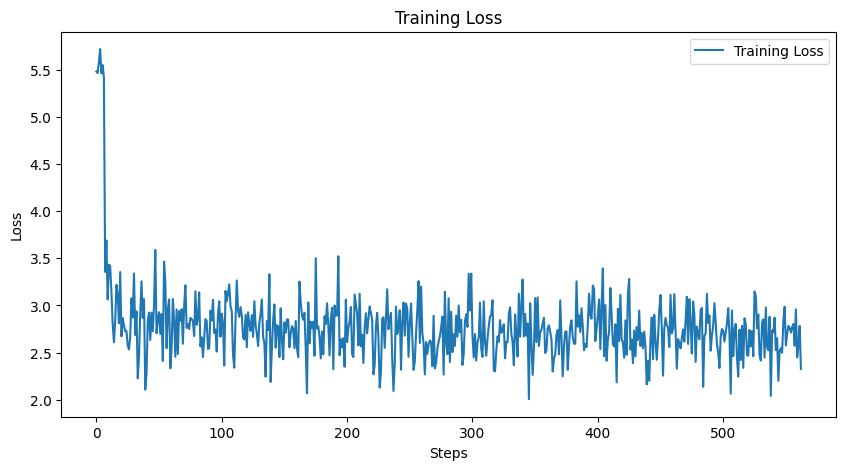

In [ ]:
training_stats = trainer.state.log_history

train_loss = [entry['loss'] for entry in training_stats if 'loss' in entry and 'eval_loss' not in entry]
eval_loss = [entry['eval_loss'] for entry in training_stats if 'eval_loss' in entry]

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

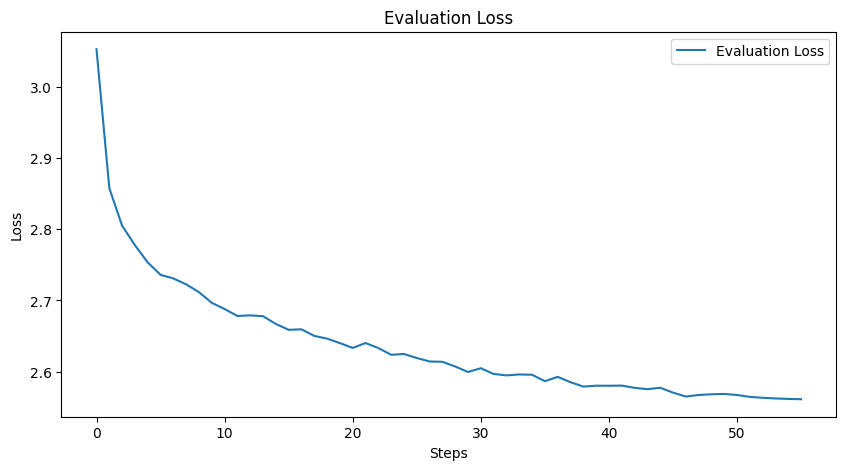

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(eval_loss, label='Evaluation Loss')
plt.title('Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()